# An ANN model to predict the Iris species

The Iris data set is one of the classical datasets used as an introduction
to machine learning.  It was introduced by [Sir Ronald Aylmer Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) (statistician and
biologist) in his 1936 paper "The use of multiple measurements in taxonomic
problems".  Consists of 150 samples, 50 for each species of the Iries
flower, named setosa, virginica and versicolor while for each sample
we meanure the length and width of the sepals and the petals.

The objective of the model we are creating here is to develop a model that 
will predict the species from the corresponing measurements.



<table>
<tr>
<th style="text-align:center">setosa</th>
<th style="text-align:center">virginica</th>
    <th style="text-align:center">versicolor</th>
</tr>
<tr>
<td><img src="./images/setosa.jpg" style="width:220px;height:220px"/></td>
<td><img src="./images/virginica.jpg" style="width:220px;height:220px"/></td>
<td><img src="./images/versicolor.jpg" style="width:220px;height:220px"/></td>
</tr>
</table>

[Ronald Fisher original paper](./data/iris-fisher.pdf)


In [1]:
from IPython.display import IFrame
IFrame("./data/iris-fisher.pdf", width="100%", height=600)

In [212]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical

In [213]:
# Load the data and randomize them.
df = pd.read_csv("./data/iris-dataset.csv")
df = df.sample(frac=1)

# Enrich the data adding a numeric column to represent the species.
species_index = { n: i for i, n in enumerate(np.unique(df["Species"]))}
df["si"] = df.apply(lambda row: species_index[row["Species"]], axis=1)
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,si
55,56,5.7,2.8,4.5,1.3,versicolor,1
125,126,7.2,3.2,6.0,1.8,virginica,2
112,113,6.8,3.0,5.5,2.1,virginica,2
21,22,5.1,3.7,1.5,0.4,setosa,0
141,142,6.9,3.1,5.1,2.3,virginica,2
...,...,...,...,...,...,...,...
143,144,6.8,3.2,5.9,2.3,virginica,2
97,98,6.2,2.9,4.3,1.3,versicolor,1
139,140,6.9,3.1,5.4,2.1,virginica,2
78,79,6.0,2.9,4.5,1.5,versicolor,1


### Check the composition of the data 

We can see that in our sample we have an equal number of 
each of the species:

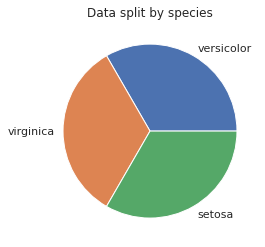

In [214]:
counters = [len(df[df["Species"] == species]) for species in df['Species'].unique()]
_ = plt.pie(counters, labels=df['Species'].unique())
_ = plt.title("Data split by species")

### Preview the Data

Our first step when we have to deal with data is to visualize them
and improve our intutive understanding of them.

The following scatter represenation gives us a hint of how the dataset
is clustered in terms of the sepal length-width in a by species basis:

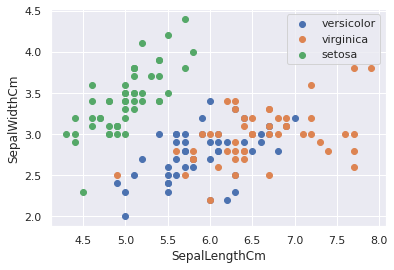

In [215]:
for species in df['Species'].unique():
    df1 = df[df['Species'] == species]
    plt.scatter(
        df1["SepalLengthCm"], df1["SepalWidthCm"], label=species
    )
_ = plt.legend()   
_ = plt.xlabel("SepalLengthCm")
_ = plt.ylabel("SepalWidthCm")


### Separate data to training and testing subsets

We are splitting the available data into two completely distict
subsets:

#### Training Data

The training data will be used to traing the NN meaning to fit
the curve to them with the minimum possible loss.
    
#### Testing Data

The testing data are compoletely separate from the testing and
are never be seem from the training phase; they are used after
the training process to verify the accurary of the model in
unseen data.


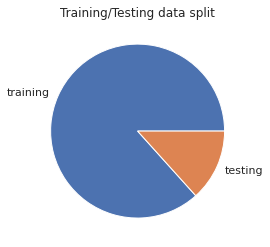

In [216]:
# Break down to testing and training data.
training_data = df.iloc[:130]
testing_data = df.iloc[130:]

_ = plt.pie([len(training_data), len(testing_data)], labels = ["training", "testing"])
_ =plt.title("Training/Testing data split")

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
input_cols = ["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]
X = training_data[cols].copy()
Y = pd.DataFrame(training_data["si"].copy())

### Split the training data to train and validation subsets

To avoid overfitting our model to the training data, we are extracting
from them a portion that we call **validation dataset** which will be used
during the training process as an "implicit" test (still not the test we
will do after the training is complete but as an intermediate testing).

In [219]:
train_X, validation_x, train_y, validation_y = train_test_split(X, Y, test_size=0.3, stratify=Y)

### Convert numerical to categorical values



In [220]:
train_y = to_categorical(train_y)
validation_y = to_categorical(validation_y)

In [221]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_X, train_y, batch_size=12, epochs=10, validation_data=(validation_x, validation_y), verbose=1)

Epoch 1/10
8/8 [==============================] - 0s 22ms/step - loss: 0.8448 - accuracy: 0.6813 - val_loss: 0.6910 - val_accuracy: 0.6923
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.5731 - accuracy: 0.7253 - val_loss: 0.4751 - val_accuracy: 0.6923
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.4425 - accuracy: 0.9121 - val_loss: 0.3739 - val_accuracy: 0.9744
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3687 - accuracy: 0.9341 - val_loss: 0.3272 - val_accuracy: 0.8462
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3337 - accuracy: 0.8791 - val_loss: 0.2705 - val_accuracy: 0.9487
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2720 - accuracy: 0.9560 - val_loss: 0.2402 - val_accuracy: 0.9487
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2369 - accuracy: 0.9341 - val_loss: 0.1861 - val_accuracy: 1.0000
Epoch 8/10
8/8 [=================

### Visualize the training phase

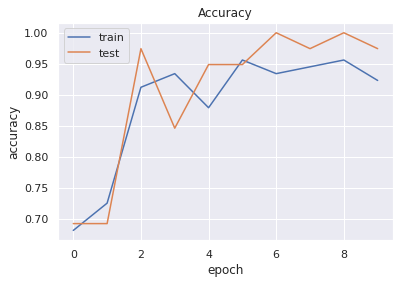

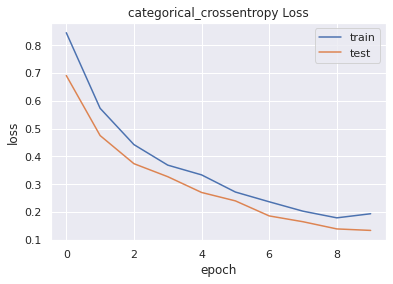

In [222]:
#Accuracy plot
plt.figure()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

#Loss plot
plt.figure()
plt.title('categorical_crossentropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


### Check accuracy on unseen data

In [223]:
testing_data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,si
88,89,5.6,3.0,4.1,1.3,versicolor,1
49,50,5.0,3.3,1.4,0.2,setosa,0
56,57,6.3,3.3,4.7,1.6,versicolor,1
103,104,6.3,2.9,5.6,1.8,virginica,2
30,31,4.8,3.1,1.6,0.2,setosa,0
0,1,5.1,3.5,1.4,0.2,setosa,0
110,111,6.5,3.2,5.1,2.0,virginica,2
119,120,6.0,2.2,5.0,1.5,virginica,2
8,9,4.4,2.9,1.4,0.2,setosa,0
72,73,6.3,2.5,4.9,1.5,versicolor,1


1/1 [==============================] - 0s 16ms/step - loss: 0.2316 - accuracy: 0.9000
Accuracy:      0.9


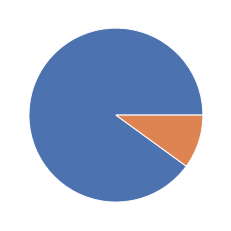

In [224]:
testing_X = testing_data[cols].copy()
testing_Y = pd.DataFrame(testing_data["si"].copy())
testing_Y = to_categorical(testing_Y)

test_loss, test_acc = model.evaluate(testing_X, testing_Y)
print(f'Accuracy: {test_acc:8.4}')
_ = plt.pie([test_acc, 1 - test_acc])

### Make adhoc prediction to unseen data 

In [225]:
x = model.predict([[54, 5.5, 2.3, 4.0]])
x1, x2, x3 = x[0]

print(round(x1), round(x2), round(x3))

1/1 [==============================] - 0s 46ms/step
1 0 0
